In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')
sns.set_style(rc=plt.rcParams)

In [3]:
from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe
from loren_frank_data_processing import make_neuron_dataframe
from loren_frank_data_processing import get_position_dataframe
from loren_frank_data_processing import get_spikes_dataframe

In [4]:
epoch_info = make_epochs_dataframe(ANIMALS)

In [5]:
epoch_key = ('HPa', 3, 2) # animal, day, epoch
position_info = get_position_dataframe(epoch_key, ANIMALS)

Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/trevortknguyen/repos/tn_decoding/src/../Raw-Data/HPa_direct/HPaDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
position_info['time_sec'] = position_info.index / np.timedelta64(1, 's')

In [7]:
neuron_info = make_neuron_dataframe(ANIMALS)
neuron_info = neuron_info.xs(epoch_key, drop_level=False)

In [8]:
def get_position_info_indices_at_spikes(spike_times_sec, position_info):
    '''
    spike_times_sec must be the times in seconds
    position_info must be modified to have a 'time_sec' column with corresponding units to spike_times_sec
    '''
    time_indices = np.empty((spike_times_sec.shape[0]), dtype='int')

    spike_time_index = 0

    for i, spike_time in enumerate(spike_times_sec):
        for index in range(spike_time_index, position_info['time_sec'].shape[0]):
            prev_index = max(0, index-1)
            prev_pos_time = position_info['time_sec'][prev_index]
            pos_time = position_info['time_sec'][index]
            # if we have gone too far
            if pos_time > spike_time:
                spike_time_index = prev_index
                break
        # time_ind (where to index into positions table)
        time_indices[i] = spike_time_index
    return time_indices

In [9]:
neuron_info.index.shape[0]

34

In [31]:
# this happens on single core
df = pd.DataFrame()

for neuron_idx in range(neuron_info.index.shape[0]):
    neuron_area = neuron_info.iloc[neuron_idx]['area']
    neuron_id = neuron_info.iloc[neuron_idx]['neuron_id']
    
    spike_times = get_spikes_dataframe(neuron_info.index[neuron_idx], ANIMALS)
    spike_times_sec = spike_times.index / np.timedelta64(1, 's')
    time_indices = get_position_info_indices_at_spikes(spike_times_sec, position_info)
    
    spike_position_info = position_info.iloc[time_indices].copy()
    spike_position_info['neuron_idx'] = neuron_idx
    spike_position_info['neuron_area'] = neuron_area
    spike_position_info['neuron_id'] = neuron_id

    
    df = df.append(spike_position_info)


<AxesSubplot:xlabel='linear_position', ylabel='neuron_idx'>

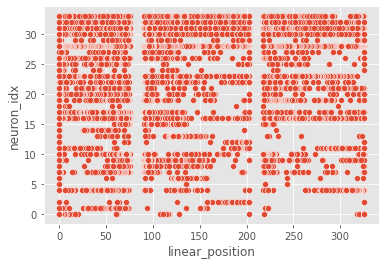

In [32]:
sns.scatterplot(x='linear_position', y='neuron_idx',
               data=df)

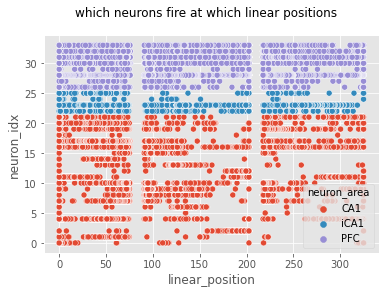

In [42]:
fig, ax = plt.subplots()
sns.scatterplot(x='linear_position', y='neuron_idx', hue='neuron_area',
               data=df,
               ax=ax)
fig.suptitle('which neurons fire at which linear positions')
fig.savefig(f'../figures/neuron_idx_firing_at_linear_position.png')

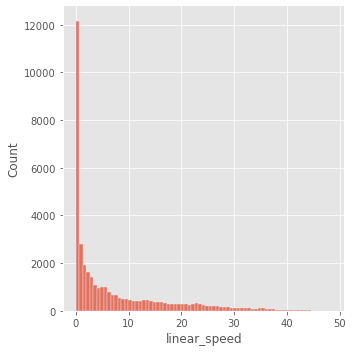

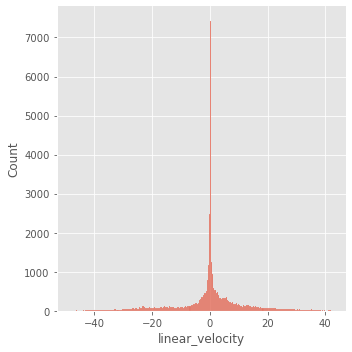

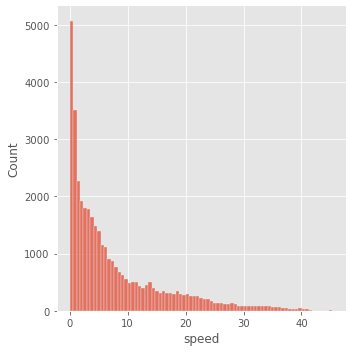

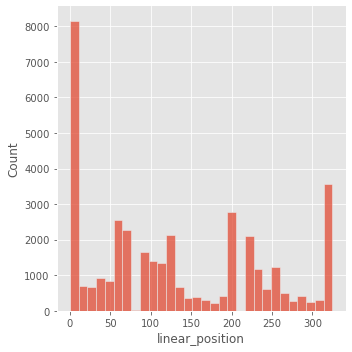

In [39]:
for x in ['linear_speed', 'linear_velocity', 'speed', 'linear_position']:
    sns.displot(x=x,
               data=position_info)

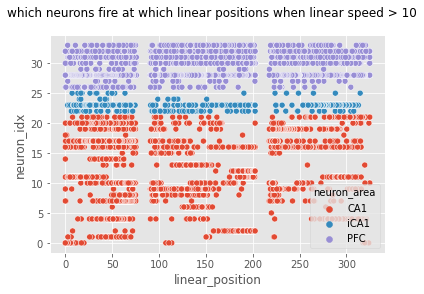

In [45]:
fig, ax = plt.subplots()
sns.scatterplot(x='linear_position', y='neuron_idx', hue='neuron_area',
               data=df[df['linear_speed'] > 10],
               ax=ax)
fig.suptitle('which neurons fire at which linear positions when linear speed > 10')
fig.savefig(f'../figures/neuron_idx_firing_at_linear_position.png')

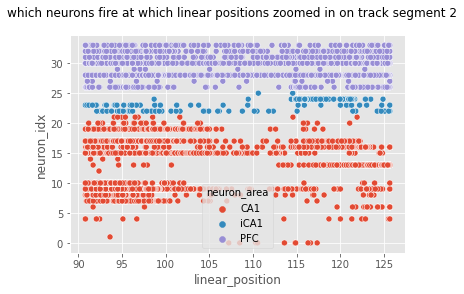

In [56]:
fig, ax = plt.subplots()
sns.scatterplot(x='linear_position', y='neuron_idx', hue='neuron_area',
               data=df[df['track_segment_id'] == 2.0],
               ax=ax)
fig.suptitle('which neurons fire at which linear positions zoomed in on track segment 2')
None

<AxesSubplot:xlabel='linear_position', ylabel='Count'>

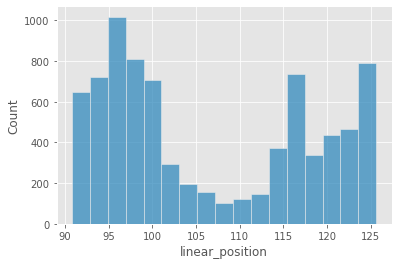

In [52]:
sns.histplot(x='linear_position',
                 data=df[df['track_segment_id'] == 2.0])